### Running all the sections is not necessary, scroll down to "Execute all of the following"

### Set Keras Configuration

In [ ]:
import os
os.environ["THEANO_FLAGS"] = "device=cpu;lib.cnmem=0.2"
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
import theano
print(theano.config.device)

In [ ]:
import src
help(src)

### Optional Tools

In [ ]:
from src.models.keras_model_utils import Model
import os

for k in range(len(model_names)):
    print ('Using:', model_names[k])
    json_file = ROOT_DIR + 'models/json/' + model_names[k] + '.json'
    yaml_file = ROOT_DIR + 'models/yaml/' + model_names[k] + '.yaml'
    weights_file = ROOT_DIR + 'models/weights/' + model_names[k] + '.hdf5'
    
    model = Model(name=model_names[k])
    model.set_to(model.load_from(json_file=json_file, yaml_file=yaml_file))
    model.load_weights(weights_file)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    models[k] = model
    print('Done\n')

In [ ]:
from types import GeneratorType
from src.models.keras_model_utils import Model
import numpy as np
import scipy.io

def test_models(inds=[]):
    print ('Predicting...')
    mini_batch_size = 32
    for k in inds:
        y_score[k] = []
        print ('Using:', model_names[k])
        if isinstance(test, GeneratorType):
            # Check if the following runs
            y_score[k] = models[k].predict_generator(generator=test,
                                                val_samples=nb_samples)
        else:
            #y_score[k] = models[k].predict(test.X_test, batch_size=mini_batch_size, verbose=1)
            y = models[k].predict(test.X_test, batch_size=mini_batch_size, verbose=1)
            for c in range(nb_classes):
                fpr, tpr, _ = roc_curve(test.y_test[:,c], y[:,c])
                roc_aucs[k][c] = (auc(fpr, tpr)
                print('AUC ({:s}): {:f}'.format(model_names[k], r))
                
            #a = {}
            #a['predictions'] = np.array(r)
            #print('Saving to y_score_{:s}.mat'.format(model_names[k]))
            #scipy.io.savemat('y_score_' + model_names[k] + '.mat', a)
        print('Done\n')
    print('Done predicting')
    
test_models([0])

In [ ]:
from src.models.test_model import main as predict_and_save
model_name = 'conv_net_large_2'
argv= [model_name, 
       ROOT_DIR + 'models/weights/'+model_name+'.hdf5', 
       ROOT_DIR + 'models/json/'+model_name+'.json', 
       ROOT_DIR + 'models/yaml/'+model_name+'.yaml', 
       ROOT_DIR + 'models/csv/'+model_name+'.csv', 
       ROOT_DIR + 'models/run_logs/tensorboard']
predict_and_save(argv)

In [ ]:
def print_2D_list(headers, matrix):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    #t = [fmt.format(*row)]
    #h = [[str(e) for e in row] for row in headers]
    #print('\n'.join([fmt.format(*row) for row in h]))
    print(lens[0])
    for h in headers:
        print('{:{width}s}\t'.format(h, width=lens[0]), end="")
    print('\n')
    print ('\n'.join(table))

print_2D_list(model_names, roc_aucs)

In [ ]:
def corresponding_elems(target=[], inds=[]):
    """
    Returns a list that contains the elements that correspond to the indices in inds
    """
    return [target[i] for i in inds]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

def gen_roc_curves(inds=[]):
    name_width = 0
    for k in inds:
        if name_width < len(model_names[k]):
            name_width = len(model_names[k])
    print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    for k in inds:
        # Calculate ROC AUC for each class
        print('\nUsing model {:s}'.format(model_names[k]))
        for c in tqdm(range(nb_classes)):
        #for c in range(10):
            fpr[k][c], tpr[k][c], _ = roc_curve(test.y_test[:,c], y_score[k][:,c])
            roc_aucs[k].append(auc(fpr[k][c], tpr[k][c]))
            #print('AUC ( {:^{width}s} )[{:3d}]: {:f}'.format(model_names[k], c, roc_aucs[k][c], width=name_width))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from tqdm import tqdm

def gen_pr_curves(inds=[]):
    name_width = 0
    for k in inds:
        if name_width < len(model_names[k]):
            name_width = len(model_names[k])
    print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    for k in inds:
        # Compute Precision-Recall and plot curve
        print('\nUsing model {:s}'.format(model_names[k]))
        for i in tqdm(range(nb_classes)):
            precision[k][i], recall[k][i], _ = precision_recall_curve(test.y_test[:, i],
                                                                y_score[k][:, i])
            pr_auc[k][i] = average_precision_score(test.y_test[:, i], y_score[k][:, i])

        # Compute micro-average ROC curve and ROC area
        precision[k]["micro"], recall[k]["micro"], _ = precision_recall_curve(y_test_ravel,
            y_score_ravel[k])
        pr_auc[k]['micro'] = average_precision_score(test.y_test, y_score[k],
                                                             average='micro')

In [ ]:
nb_models = len(model_names)
nb_classes = len(test.y_test)
nb_classes = len(test.y_test[0])

# Populate with zeros to retain indices even if ROC curves are not generated for that model
models = [0]*nb_models
y_score = [0]*nb_models
y_score_ravel = [0]*nb_models

roc_aucs = [[] for x in range(len(model_names))]

precision = [{} for i in range(nb_models)]
recall = [{} for i in range(nb_models)]
pr_auc= [{} for i in range(nb_models)]

In [ ]:
print('Creating y_test_ravel...')
y_test_ravel = test.y_test.ravel()

#print('Creating y_score_ravel...')
#for k in range(nb_models):
    #y_score_ravel[k] = y_score[k].ravel()

In [ ]:
gen_roc_curves(model_inds)

In [ ]:
load_predictions([0])

In [ ]:
gen_pr_curves(model_inds)

In [ ]:
import scipy.io
from os.path import isfile

def load_predictions(inds=[]):
    for k in inds:
        f = ROOT_DIR + 'models/predictions/y_predict_' + model_names[k] + '.mat'
        print('Loading scipy.io mat from "{:s}"...'.format(f))
        y_score[k] = scipy.io.loadmat(f)['predictions']
    print('Done')

In [ ]:
load_roc_aucs(model_inds)
load_fpr_tpr(model_inds)
load_pr_aucs(model_inds)
load_pr(model_inds)

## Execute all of the following

### Get File Structure

In [37]:
import os
import sys
from dotenv import load_dotenv, find_dotenv

# Find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# Load up the entries as environment variables
load_dotenv(dotenv_path)

# Get the directories of the project based off of '.env' which is in the root directory
ROOT_DIR = os.path.join(dotenv_path, os.pardir)
ROOT_DIR = dotenv_path[:-len('.env')] # Strip .env from dotenv_path to get root directory
SRC_DIR = ROOT_DIR + 'src/'

print('ROOT_DIR = {:s}'.format(ROOT_DIR))
print('SRC_DIR = {:s}'.format(SRC_DIR))

sys.path.append(os.path.normpath(ROOT_DIR))

ROOT_DIR = /home/minhoolee/Github/Synopsys-Project-2017/
SRC_DIR = /home/minhoolee/Github/Synopsys-Project-2017/src/


In [2]:
opp = 'State of the Art'
mine = 'My Model'
import matplotlib.pyplot as plt

width, height = 20, 5
plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 18})

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from tqdm import tqdm

def gen_roc_curves(inds=[]):
    print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    for k in inds:
        print('Using model {:s}'.format(model_names[k]))
        f = ROOT_DIR + 'models/predictions/y_predict_' + model_names[k] + '.mat'
        print('Loading scipy.io mat from "{:s}"...'.format(f))
        y_score = scipy.io.loadmat(f)['predictions']
        # Calculate ROC AUC for each class
        print('Using model {:s}\n'.format(model_names[k]))
        
        fpr = [np.nan] * nb_classes
        tpr = [np.nan] * nb_classes
        roc_auc = [] 
        for c in tqdm(range(nb_classes)):
            fpr[c], tpr[c], _ = roc_curve(test.y_test[:,c], y_score[:,c])
            roc_auc.append(auc(fpr[c], tpr[c]))
            
        a = {}
        #a['fpr'] = np.array(fpr)
        #a['tpr'] = np.array(tpr)
        #a['roc_aucs'] = np.array(roc_aucs)
        a['fpr'] = fpr
        a['tpr'] = tpr
        a['roc_auc'] = roc_auc
        filepath = ROOT_DIR + 'models/stats/roc_scores/y_roc_{:s}.mat'.format(model_names[k])
        print('\nSaving to {:s}...\n'.format(filepath))
        scipy.io.savemat(filepath, a)

In [4]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from tqdm import tqdm

def gen_pr_curves(inds=[]):
    print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    y_test_ravel = test.y_test.ravel()
    for k in inds:
        # Compute Precision-Recall and plot curve
        print('Using model {:s}'.format(model_names[k]))
        f = ROOT_DIR + 'models/predictions/y_predict_' + model_names[k] + '.mat'
        print('Loading scipy.io mat from "{:s}"...'.format(f))
        y_score = scipy.io.loadmat(f)['predictions']
        precision = [np.nan] * nb_classes
        recall = [np.nan] * nb_classes
        pr_auc = [np.nan] * nb_classes
        
        for i in tqdm(range(nb_classes)):
            precision[i], recall[i], _ = precision_recall_curve(test.y_test[:, i],
                                                                y_score[:, i])
            pr_auc[i] = average_precision_score(test.y_test[:, i], y_score[:, i])
            
        precision_micro = np.nan
        recall_micro = np.nan
        pr_auc_micro = np.nan
        
        print('Generating micro-average PR curve')
        # Compute micro-average PR curve and PR area
        precision_micro, recall_micro, _ = precision_recall_curve(y_test_ravel,
            y_score.ravel())
        
        print('Generating micro-average PR AUC')
        pr_auc_micro = average_precision_score(test.y_test, y_score,
                                                            average='micro')
            
        a = {}
        a['precision']       = precision
        a['micro_precision'] = precision_micro
        a['recall']          = recall
        a['micro_recall']    = recall_micro
        a['pr_auc']          = pr_auc
        a['micro_pr_auc']    = pr_auc_micro
        filepath = ROOT_DIR + 'models/stats/pr_scores/y_pr_{:s}.mat'.format(model_names[k])
        print('\nSaving to {:s}...\n'.format(filepath))
        scipy.io.savemat(filepath, a)

In [5]:
def gen_stats(inds=[]):
    #for i, d
    print('not yet')

In [6]:
import scipy.io
from os.path import isfile
def load_roc_aucs(inds=[]):
    for k in inds:
        f = ROOT_DIR + 'models/stats/roc_scores/y_roc_' + model_names[k] + '.mat'
        if not isfile(f):
            print('Generating ROC curves for {:s}'.format(model_names[k]))
            gen_roc_curves([k])
        print('Loading scipy.io mat from "{:s}"...'.format(f))
        file = scipy.io.loadmat(f)
        roc_aucs[k] = file['roc_auc'][0]
    print('Done')

In [7]:
import scipy.io
def load_fpr_tpr(inds=[]):
    for k in inds:
        f = ROOT_DIR + 'models/stats/roc_scores/y_roc_' + model_names[k] + '.mat'
        if not isfile(f):
            print('Generating ROC curves for {:s}'.format(model_names[k]))
            gen_pr_curves([k])
        print('Loading scipy.io mat from "{:s}"...'.format(f))
        file = scipy.io.loadmat(f)
        fpr[k] = file['fpr'][0]
        tpr[k] = file['tpr'][0]
    print('Done')

In [8]:
import scipy.io
def load_pr(inds=[]):
    for k in inds:
        f = ROOT_DIR + 'models/stats/pr_scores/y_pr_' + model_names[k] + '.mat'
        if not isfile(f):
            print('Generating PR curves for {:s}'.format(model_names[k]))
            gen_pr_curves([k])
        print('Loading scipy.io mat from "{:s}"...'.format(f))
        file = scipy.io.loadmat(f)
        precision[k] = file['precision'][0]
        recall[k] = file['recall'][0]
        micro_precision[k] = file['micro_precision'][0]
        micro_recall[k] = file['micro_recall'][0]
    print('Done')

In [9]:
import scipy.io
def load_pr_aucs(inds=[]):
    for k in inds:
        f = ROOT_DIR + 'models/stats/pr_scores/y_pr_' + model_names[k] + '.mat'
        if not isfile(f):
            print('Generating PR curves for {:s}'.format(model_names[k]))
            gen_pr_curves([k])
        print('Loading scipy.io mat from "{:s}"...'.format(f))
        file = scipy.io.loadmat(f)
        pr_aucs[k] = file['pr_auc'][0]
        micro_pr_aucs[k] = file['micro_pr_auc'][0]
    print('Done')

In [10]:
import matplotlib.pyplot as plt
def plot_roc_curves(inds=[]):
    plt.clf()
    plt.figure(figsize=(10, 10))
    for k in inds:
        # ROC AUC for the model has not been created
        if k not in fpr or k not in tpr:
            load_fpr_tpr([k])
        if k not in roc_aucs:
            load_roc_aucs([k])
            
        #for c in range(nb_classes):
        for c in range(5):
            plt.plot(fpr[k][0][c], tpr[k][0][c], label='ROC curve (area = %0.2f)' % roc_aucs[k][c])
            
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
            
    #plt.legend(model_names[i] for i in inds, loc='lower right')
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves')

    # Plot ROC curves
    #print('Plotting ROC curves...')
    plt.show()
    plt.savefig(ROOT_DIR + 'models/run_logs/auc.png', bbox_inches='tight') # Temporary

In [11]:
def plot_roc_aucs(a, b):
    plt.clf()
    plt.figure(figsize=(10, 10))
    inds = [a, b]
    # Check if ROC AUCs are loaded first
    for k in inds:
        if k not in roc_aucs:
            load_roc_aucs([k])
            
    for k in inds:
        for c in range(nb_classes):
            plt.scatter(roc_aucs[a][c], roc_aucs[b][c], s=10, c='b', alpha=0.5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    #plt.xlabel(model_names[a])
    #plt.ylabel(model_names[b])
    plt.xlabel(opp)
    plt.ylabel(mine)
    #print('Generating curves for ' + ', '.join(model_names[i] for i in indscorr))
    plt.title('Area Under the Receiver Operating Characteristic Curves')
    # Plot ROC curves
    #print('Plotting ROC AUCs...')
    plt.show()
    plt.savefig(ROOT_DIR + 'models/run_logs/aucs.png', bbox_inches='tight') # Temporary

In [12]:
def plot_roc_aucs_vs_other(ind, roc_aucs_arr, other_name="Competitor"):
    """
    # Arguments
        ind: 
            index of inds list to use
        roc_aucs_arr:
            one dimensional numpy array of ROC AUC scores
        other_name:
            name of other model
    """
    plt.clf()
    plt.figure(figsize=(10, 10))
    if ind not in roc_aucs:
        load_roc_aucs([ind])
    for c in range(nb_classes):
        plt.scatter(roc_aucs_arr[c], roc_aucs[ind][c], s=10, c='b', alpha=0.5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel(opp)
    plt.ylabel(mine)
    #plt.xlabel(other_name)
    #plt.ylabel(model_names[ind])
    plt.title('Area Under the Receiver Operating Characteristic Curves')
    # Plot ROC curves
    #print('Plotting ROC AUCs...')
    plt.show()
    plt.savefig(ROOT_DIR + 'models/run_logs/aucs.png', bbox_inches='tight') # Temporary

In [13]:
def plot_roc_aucs_others(arr_1, arr_2, arr_1_name="Competitor 1", arr_2_name="Competitor 2"):
    plt.clf()
    plt.figure(figsize=(10, 10))
    for c in range(nb_classes):
        plt.scatter(arr_1[c], arr_2[c], s=10, c='b', alpha=0.5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel(arr_1_name)
    plt.ylabel(arr_2_name)
    plt.title('Area Under the Receiver Operating Characteristic Curves')
    # Plot ROC curves
    #print('Plotting ROC AUCs...')
    plt.show()
    plt.savefig(ROOT_DIR + 'models/run_logs/aucs.png', bbox_inches='tight') # Temporary

In [14]:
def plot_roc_aucs_diffs(a, b):
    """
    Plot relative improvement of aucs for two models, a is positive, b is negative
    """
    plt.clf()
    plt.figure(figsize=(15, 10))
    
    scale = 100
    inds = [a, b]
    # Check if ROC AUCs are loaded first
    for k in inds:
        if k not in roc_aucs:
            load_roc_aucs([k])
            
    for k in inds:
        max_diff = 0
        min_diff = 1 # Dummy value
        for c in range(nb_classes):
            diff = (roc_aucs[a][c]-roc_aucs[b][c]) / roc_aucs[b][c] # Assume roc_aucs[a][c] is larger
            if diff > max_diff:
                max_diff = diff
            if diff < min_diff:
                min_diff = diff
            plt.scatter(c, scale * diff, s=10, c='b', alpha=0.5)
        
    max_diff = abs(max_diff)
    min_diff = abs(min_diff)
    #scale = 1.1 * (max_diff if max_diff > min_diff else min_diff) # Scale with greatest magnitude
    plt.plot([0, nb_classes], [0, 0], 'k--')
    plt.xlim([0.0, nb_classes])
    plt.ylim([-scale, scale])
    plt.xlabel('Epigenetic Class')
    #plt.ylabel(model_names[a] + ' minus ' + model_names[b])
    plt.ylabel('Relative Improvement')
    #print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    plt.title('Relative Improvement of My Model\'s Area Under the Receiver Operating Characteristic Curves')
    # Plot ROC curves
    #print('Plotting ROC AUCs...')
    plt.show()
    plt.savefig(ROOT_DIR + 'models/run_logs/aucs.png', bbox_inches='tight') # Temporary

In [15]:
def plot_relative_improvements(a, b, scale=100):
    """
    Plot relative improvement of aucs for two models, a is positive, b is negative
    """
    plt.clf()
    plt.figure(figsize=(15, 10))
    
    datasets = [a, b]
    diff = [0] * nb_classes
    for c in range(nb_classes):
        diff[c] = (a[c]-b[c]) / b[c] # Assume roc_aucs[a][c] is larger
        
    plt.scatter(range(nb_classes), [100 * d for d in diff], s=10, c='b', alpha=0.5)
    #plt.scatter(range(nb_classes), diff, s=10, c='b', alpha=0.5)
        
    plt.plot([0, nb_classes], [0, 0], 'k--')
    plt.xlim([-1, nb_classes+1])
    plt.ylim([-scale, scale])
    plt.xlabel('Epigenetic Class')
    #plt.ylabel(model_names[a] + ' minus ' + model_names[b])
    plt.ylabel('Relative Improvement (%)')
    #print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    plt.title('Relative Improvement of My Model\'s Area Under the Receiver Operating Characteristic Curves')
    plt.title('Relative Comparison of ROC AUC Scores')
    plt.title('Relative Comparison of PR AUC Scores')
    #plt.title('Relative Improvement of My Model\'s Area Under the Precision-Recall Curves')
    # Plot ROC curves
    #print('Plotting ROC AUCs...')
    plt.show()
    plt.savefig(ROOT_DIR + 'models/run_logs/aucs.png', bbox_inches='tight') # Temporary
    

In [16]:
def human_readable_string(list):
    return ', '.join('"{:s}"'.format(str(i)) for i in list)

In [17]:
assert human_readable_string([1, 2, '3']) == '"1", "2", "3"'

In [18]:
import sys

def check_if_valid(list, valid_list):
    invalid_list = [m for m in list if m not in valid_list]
    if invalid_list:
        print('ERROR - unsupported {:s}'.format(human_readable_string(invalid_list)))
        print('Supported are {:s}'.format(human_readable_string(valid_list)))
        sys.exit(1)

In [19]:
def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.1)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height),
                ha='center', va='bottom')

In [20]:
import matplotlib.pyplot as plt
from statistics import *
import sys

def plot_median_error_bar_graphs(datasets=[], metric='mean', error='stdev'):
    """
    Plots metric value and error value for N datasets
    
    # Arguments:
        datasets:
            List of datasets which are each a one dimensional list of values
        metric:
            Type of metric value to create bar graphs from for each dataset
        error:
            Type of error value to create bar graph errors from for each dataset
    """
    valid_metrics = ['mean', 'median', 'mode']
    valid_errors = ['stdev', 'variance']
    check_if_valid([metric], valid_metrics)
    check_if_valid([error], valid_errors)
    
    plt.clf()
    plt.figure(figsize=(10, 20))
    fig, ax = plt.subplots()
    width = 0.35
    y_scale = 100
    for i, d in enumerate(datasets):
        d = [y_scale * x for x in d if not np.isnan(x)]
        if metric is 'mean':
            score = mean(d)
        elif metric is 'median':
            score = median(d)
        elif metric is 'mode':
            score = mode(d)
        if error is 'stdev':
            score_err = stdev(d)
        elif error is 'variance':
            score_err = variance(d)
            
        if np.isnan(score):
            print('ERROR - invalid metric')
            sys.exit(1)
        if np.isnan(score_err):
            print('ERROR - invalid error')
            sys.exit(1)
            
        print("Model {:d} {:10s} = {:f}".format(i, metric, score))
        print("Model {:d} {:10s} = {:f}\n".format(i, error, score_err))
        rect = ax.bar(i + 1, score, width, color='b', yerr=score_err)
        autolabel(rect, ax)
    
    ax.set_xlabel(ROOT_DIR + 'models')
    ax.set_ylabel('Metrics')
    plt.xlim([0, len(datasets) + 1])
    plt.ylim([0, 1.05 * y_scale])
    plt.title('Bar graphs of metric and error for models')
    plt.show()

In [21]:
def plot_interpolated_pr_curves(inds):
    """
    Do not run this yet, I have not tested it
    
    http://stackoverflow.com/questions/39836953/how-to-draw-a-precision-recall-curve-with-interpolation-in-python
    """
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),scores.ravel())
    pr = copy.deepcopy(precision[0])
    rec = copy.deepcopy(recall[0])
    prInv = np.fliplr([pr])[0]
    recInv = np.fliplr([rec])[0]
    j = rec.shape[0]-2
    while j>=0:
        if prInv[j+1]>prInv[j]:
            prInv[j]=prInv[j+1]
        j=j-1
    decreasing_max_precision = np.maximum.accumulate(prInv[::-1])[::-1]
    plt.plot(recInv, decreasing_max_precision, marker= markers[mcounter], label=methodNames[countOfMethods]+': AUC={0:0.2f}'.format(pr_auc[0]))

In [22]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_pr_aucs(a, b):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
    
    # Arguments:
        a: 
            index of x axis model
        b:
            index of y axis model
    """
    plt.figure(figsize=(10, 10))
    inds = [a,b]
    print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    for k in inds:
        print('Using model {:s}'.format(model_names[k]))
        if k not in precision or k not in recall:
            load_pr([k])
        if k not in pr_aucs:
            load_pr_aucs([k])
            
    for k in inds:
        # Plot Precision-Recall curve for each class
        plt.clf()
        for c in range(nb_classes):
            plt.scatter(pr_aucs[a][c], pr_aucs[b][c], s=10, c='b', alpha=0.5)
        plt.scatter(micro_pr_aucs[a][0], micro_pr_aucs[b][0], s=20, c='red', alpha=0.5, label='micro AUC')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    #plt.xlabel(model_names[a])
    #plt.ylabel(model_names[b])
    plt.xlabel(opp)
    plt.ylabel(mine)
    plt.title('Area Under the Precision-Recall Curves')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
def plot_pr_curves(inds=[]):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
    """
    plt.figure(figsize=(10, 10))
    print('Generating curves for ' + ', '.join(model_names[i] for i in inds))
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
    lw = 2
    
    for k in inds:
        print('Using model {:s}'.format(model_names[k]))
        if k not in precision or k not in recall:
            load_pr([k])
        if k not in pr_aucs:
            load_pr_aucs([k])
            
        # Plot Precision-Recall curve for each class
        plt.clf()
        print('Graphing micro-average')
        plt.plot(micro_recall[k][0], micro_precision[k][0], color='gold', lw=lw,
                 label='Micro-average precision-recall curve of {:s}'.format(model_names[k]))
        print('Graphing PR curves')
        #for i, color in zip(range(nb_classes), colors):
        for i, color in zip(range(2), colors):
            # TODO: Fix this weird savemat, loadmat thing
            plt.plot(recall[k][i][0], precision[k][i][0], c=color, lw=lw,
                     label='PR curve (area = {:f})'.format(pr_aucs[k][i]))
        print('Done')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-recall curves of {:s}'.format(model_names[k]))
        plt.legend(loc="upper right")
        plt.show()

### Runnable commands

In [24]:
#from src.visualization.stats import *
# TODO: move to file

In [25]:
import os
os.environ["THEANO_FLAGS"] = "device=cpu"

In [26]:
model_names = ['danq_env',
               'conv_net_large_1', 
               'conv_net_large_res_5',
               'conv_net_large_2', 
               'danq_17',
               'conv_net_large_res_2', 
               'conv_net_large_res_1']
model_inds = list(range(len(model_names)))

for i in range(len(model_names)):
    print ('{:d}: {:s}'.format(i, model_names[i]))

0: danq_env
1: conv_net_large_1
2: conv_net_large_res_5
3: conv_net_large_2
4: danq_17
5: conv_net_large_res_2
6: conv_net_large_res_1


In [31]:
import keras.backend as K

from src.data.data_utils import ModelData
from src.logging import log_utils

TRUNCATE_DATASET_RATIO = 0.5

_log = log_utils.logger(__name__)

# Configure the tensorflow session to not run out of memory
if (K.backend() == 'tensorflow'):
    from keras.backend.tensorflow_backend import set_session
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.95
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

print ('Retrieving train, validation, and test data')
data = ModelData(test=(ROOT_DIR + 'data/processed/test.mat', 'testxdata', 'testdata'))
#train = data.get_train_tuple()
#valid = data.get_valid_tuple()
test = data.get_test_tuple()
nb_samples = len(test.y_test)
nb_classes = len(test.y_test[0])

print('Done')

Retrieving train, validation, and test data
Done


In [32]:
nb_models = len(model_names)
nb_classes = 919

# Populate with zeros to retain indices even if ROC curves are not generated for that model
models = [0]*nb_models
#y_score = [0]*nb_models
y_score_ravel = [0]*nb_models

fpr = {}
tpr = {}
roc_aucs = {}

precision = {}
recall = {}
pr_aucs = {}
micro_precision = {}
micro_recall = {}
micro_pr_aucs = {}

In [33]:
import scipy.io
competitor_aucs = scipy.io.loadmat(ROOT_DIR + 'models/stats/competitor_aucs.mat')

deepsea_roc_auc = competitor_aucs['deepsea_roc_auc']
danq_roc_auc = competitor_aucs['danq_roc_auc']
danq_jaspar_roc_auc = competitor_aucs['danq_jaspar_roc_auc']

deepsea_pr_auc = competitor_aucs['deepsea_pr_auc']
danq_pr_auc = competitor_aucs['danq_pr_auc']
danq_jaspar_pr_auc = competitor_aucs['danq_jaspar_pr_auc']

In [34]:
for i in range(len(model_names)):
    print ('{:d}: {:s}'.format(i, model_names[i]))

0: danq_env
1: conv_net_large_1
2: conv_net_large_res_5
3: conv_net_large_2
4: danq_17
5: conv_net_large_res_2
6: conv_net_large_res_1


Using danq_17 and conv_net_large_res_5
Loading scipy.io mat from "/home/minhoolee/Github/Synopsys-Project-2017/models/stats/roc_scores/y_roc_danq_17.mat"...
Done
Loading scipy.io mat from "/home/minhoolee/Github/Synopsys-Project-2017/models/stats/roc_scores/y_roc_conv_net_large_res_5.mat"...
Done


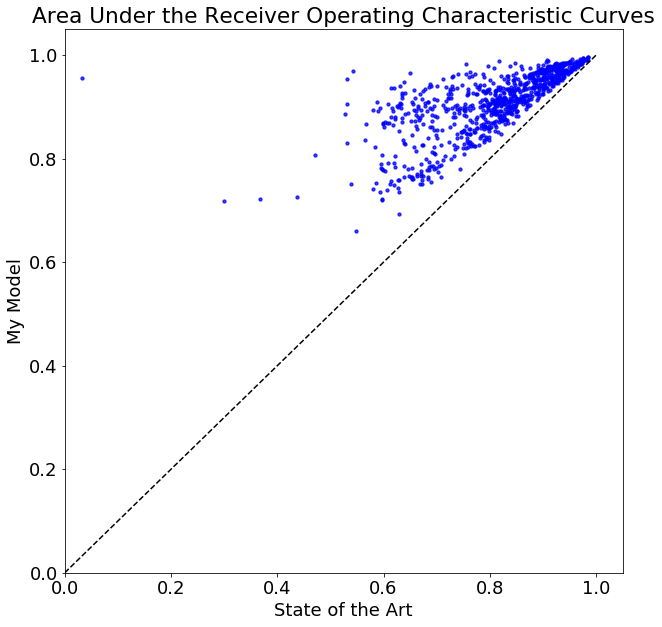

Generating curves for danq_17, conv_net_large_res_5
Using model danq_17
Loading scipy.io mat from "/home/minhoolee/Github/Synopsys-Project-2017/models/stats/pr_scores/y_pr_danq_17.mat"...
Done
Loading scipy.io mat from "/home/minhoolee/Github/Synopsys-Project-2017/models/stats/pr_scores/y_pr_danq_17.mat"...
Done
Using model conv_net_large_res_5
Loading scipy.io mat from "/home/minhoolee/Github/Synopsys-Project-2017/models/stats/pr_scores/y_pr_conv_net_large_res_5.mat"...
Done
Loading scipy.io mat from "/home/minhoolee/Github/Synopsys-Project-2017/models/stats/pr_scores/y_pr_conv_net_large_res_5.mat"...
Done


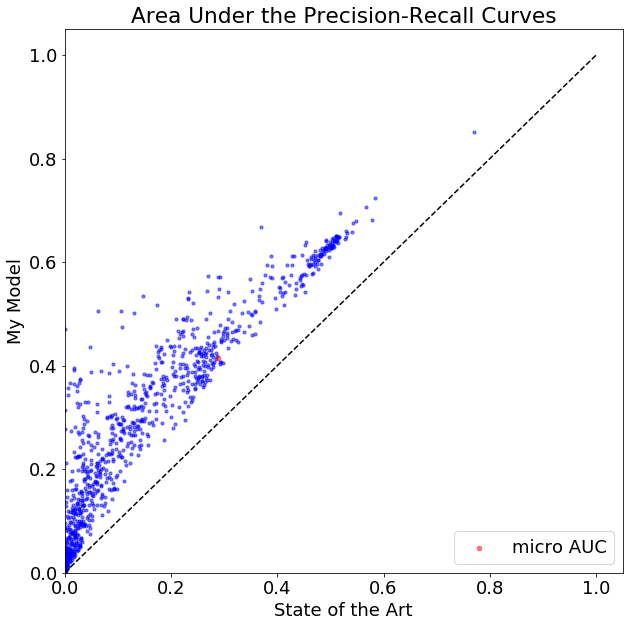

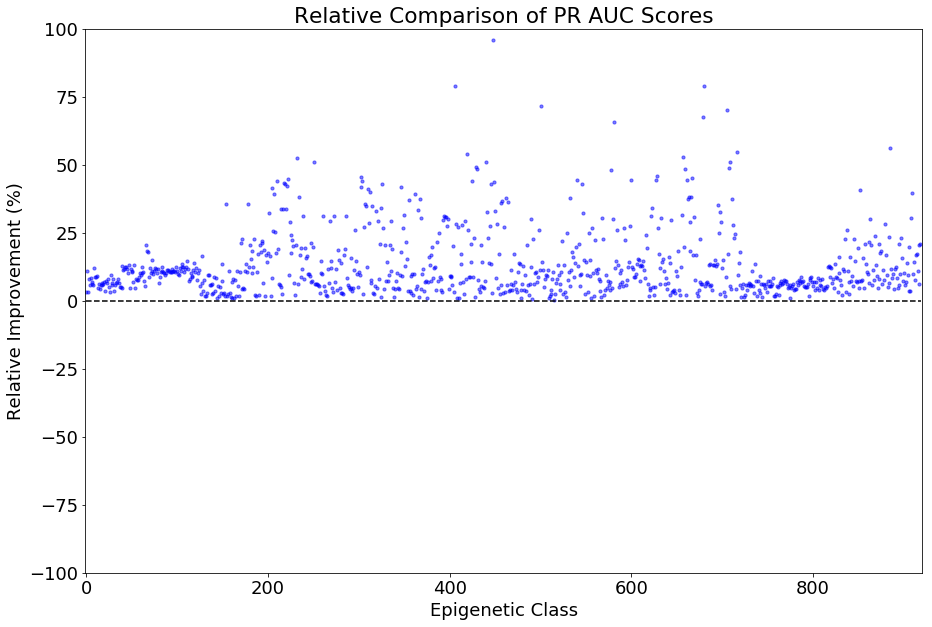

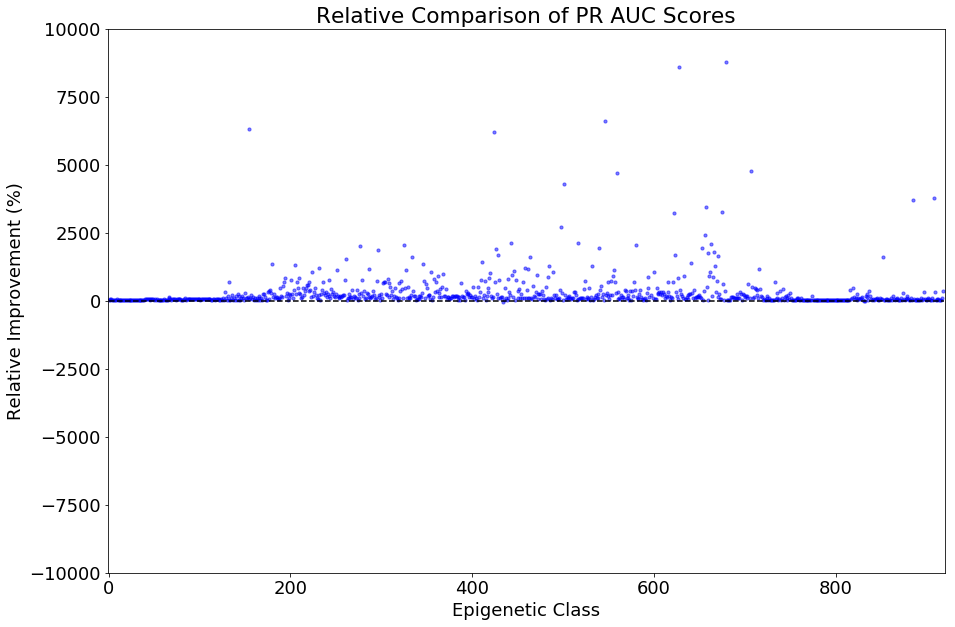

Model 0 mean       = 81.455213
Model 0 stdev      = 10.982611

Model 1 mean       = 91.283100
Model 1 stdev      = 6.034446



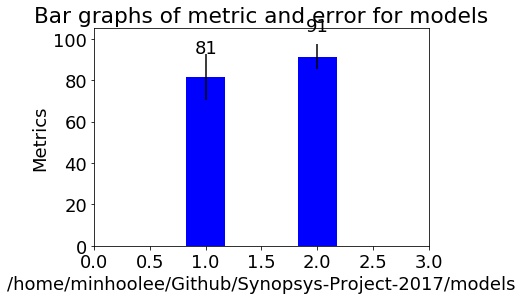

In [35]:
inds = [4, 2]
print('Using {:s} and {:s}'.format(model_names[inds[0]], model_names[inds[1]]))
#plot_roc_curves([inds[0]])
#plot_roc_curves([inds[1]])
plot_roc_aucs(inds[0], inds[1])
plot_pr_aucs(inds[0], inds[1])
plot_relative_improvements(roc_aucs[inds[1]], roc_aucs[inds[0]], scale=100)
plot_relative_improvements(pr_aucs[inds[1]], pr_aucs[inds[0]], scale=10000)
plot_median_error_bar_graphs([roc_aucs[inds[0]], roc_aucs[inds[1]]])

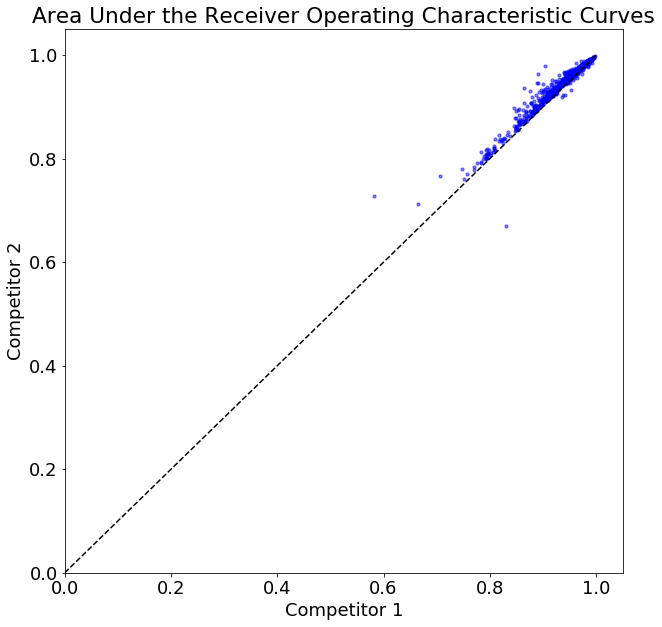

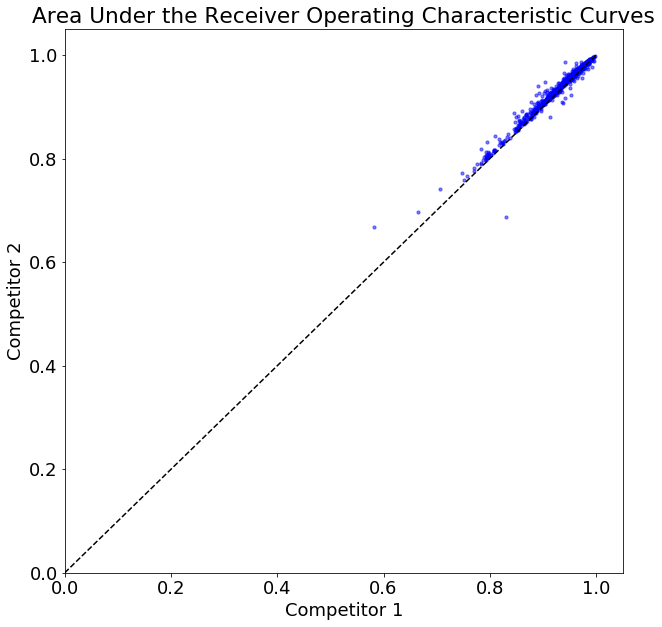

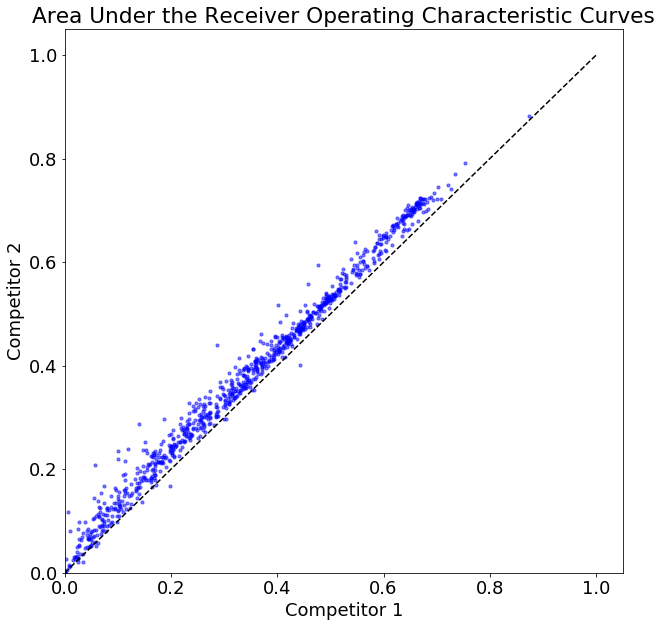

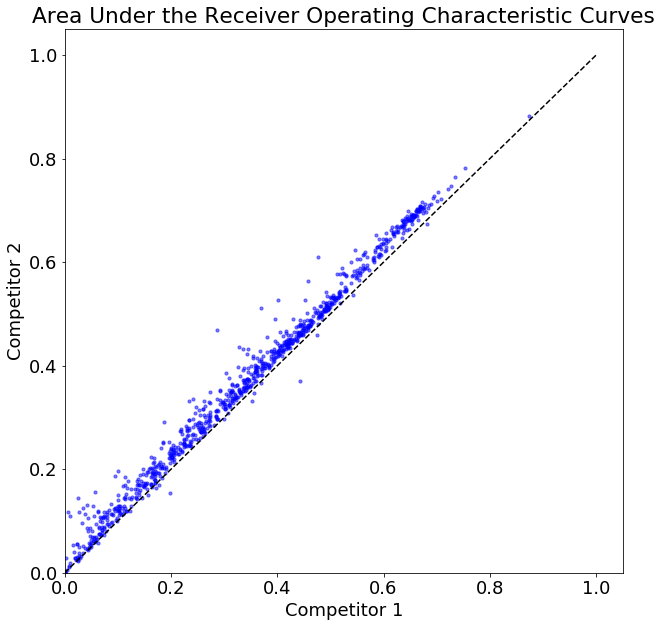

In [36]:
plot_roc_aucs_others(deepsea_roc_auc, danq_jaspar_roc_auc)
plot_roc_aucs_others(deepsea_roc_auc, danq_roc_auc)
plot_roc_aucs_others(deepsea_pr_auc, danq_jaspar_pr_auc)
plot_roc_aucs_others(deepsea_pr_auc, danq_pr_auc)